In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  GridSearchCV, cross_val_score
from pycaret.classification import *

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble._weight_boosting import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, recall_score

In [2]:
deposit_df=pd.read_csv("term-deposit-marketing-2020.csv")
deposit_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

In [3]:
deposit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
# See Null values for all the columns
deposit_df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [5]:
for i in deposit_df.columns:
    print(f'{i}: {deposit_df[i].unique()}')

age: [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]
job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
education: ['tertiary' 'secondary' 'unknown' 'primary']
default: ['no' 'yes']
balance: [  2143     29      2 ...   7222   3402 102127]
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
day: [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
duration: [ 261  151   76 ... 1880 1460 2219]
campaign: [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 

# EXPLORATORY DATA ANALYSIS

In [6]:
data1 = deposit_df[deposit_df['y'] == 'yes']
data2 = deposit_df[deposit_df['y'] == 'no']

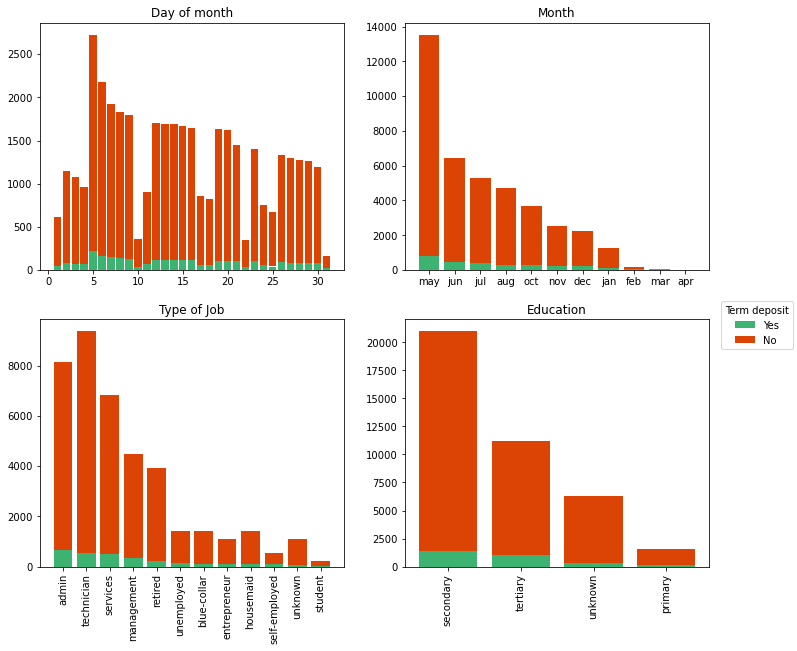

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

b1 = ax[0, 0].bar(data1['day'].unique(),height = data1['day'].value_counts(),color='#3cb371')
b2 = ax[0, 0].bar(data2['day'].unique(),height = data2['day'].value_counts(),bottom = data1['day'].value_counts(),color = '#DC4405') 
ax[0, 0].title.set_text('Day of month')
#ax[0, 0].legend((b1[0], b2[0]), ('Yes', 'No'))
ax[0, 1].bar(data1['month'].unique(),height = data1['month'].value_counts(),color='#3cb371')
ax[0, 1].bar(data2['month'].unique(),height = data2['month'].value_counts(),bottom = data1['month'].value_counts(),color = '#DC4405') 
ax[0, 1].title.set_text('Month')
ax[1, 0].bar(data1['job'].unique(),height = data1['job'].value_counts(),color='#3cb371')
ax[1, 0].bar(data1['job'].unique(),height = data2['job'].value_counts()[data1['job'].value_counts().index],bottom = data1['job'].value_counts(),color = '#DC4405') 
ax[1, 0].title.set_text('Type of Job')
ax[1, 0].tick_params(axis='x',rotation=90)
ax[1, 1].bar(data1['education'].unique(),height = data1['education'].value_counts(),color='#3cb371') #row=0, col=1
ax[1, 1].bar(data1['education'].unique(),height = data2['education'].value_counts()[data1['education'].value_counts().index],bottom = data1['education'].value_counts(),color = '#DC4405') 
ax[1, 1].title.set_text('Education')
ax[1, 1].tick_params(axis='x',rotation=90)
#ax[0, 1].xticks(rotation=90)
plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

- More phone calls are made in earlier days of the month compared to end of the month.
- May is the most targeted month followed by consecutive months.
- Jobs such as admin, technician and services are more targeted than other professions.
- people with secondary education are highly targeted.

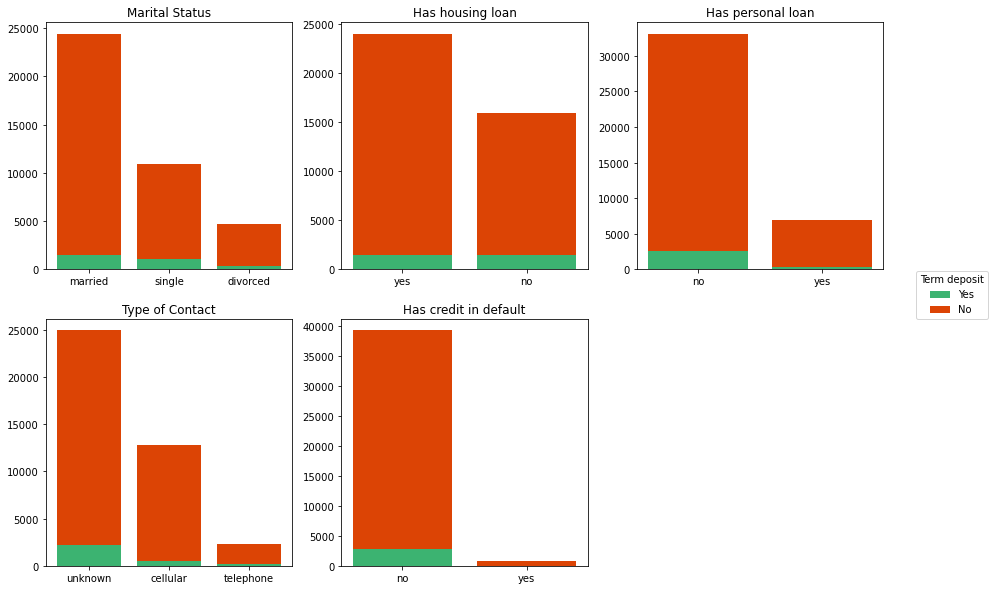

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))

b1 = ax[0, 0].bar(data1['marital'].unique(),height = data1['marital'].value_counts(),color='#3cb371')
b2 = ax[0, 0].bar(data1['marital'].unique(),height = data2['marital'].value_counts()[data1['marital'].value_counts().index],bottom = data1['marital'].value_counts(),color = '#DC4405') 
ax[0, 0].title.set_text('Marital Status')
#ax[0, 0].legend((b1[0], b2[0]), ('Yes', 'No'))
ax[0, 1].bar(data1['housing'].unique(),height = data1['housing'].value_counts(),color='#3cb371')
ax[0, 1].bar(data1['housing'].unique(),height = data2['housing'].value_counts()[data1['housing'].value_counts().index],bottom = data1['housing'].value_counts(),color = '#DC4405') 
ax[0, 1].title.set_text('Has housing loan')
ax[0, 2].bar(data1['loan'].unique(),height = data1['loan'].value_counts(),color='#3cb371')
ax[0, 2].bar(data1['loan'].unique(),height = data2['loan'].value_counts()[data1['loan'].value_counts().index],bottom = data1['loan'].value_counts(),color = '#DC4405') 
ax[0, 2].title.set_text('Has personal loan')
ax[1, 0].bar(data1['contact'].unique(),height = data1['contact'].value_counts(),color='#3cb371')
ax[1, 0].bar(data1['contact'].unique(),height = data2['contact'].value_counts()[data1['contact'].value_counts().index],bottom = data1['contact'].value_counts(),color = '#DC4405') 
ax[1, 0].title.set_text('Type of Contact')
ax[1,1].bar(data1['default'].unique(),height = data1['default'].value_counts(),color='#3cb371')
ax[1,1].bar(data1['default'].unique(),height = data2['default'].value_counts()[data1['default'].value_counts().index],bottom = data1['default'].value_counts(),color = '#DC4405') 
ax[1,1].title.set_text('Has credit in default')
ax[1,2].remove()
plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")


- Generally people who are married,have housing loan and/or personal loan and non defaulters are targeted.

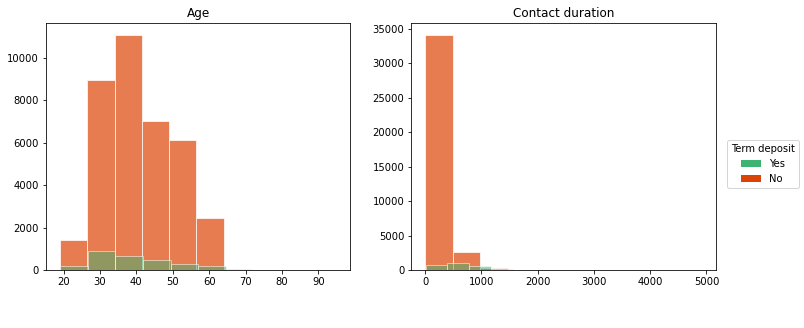

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

ax[0, 0].hist(data2['age'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[0, 0].hist(data1['age'],color='#3cb371',alpha=0.5, edgecolor='white')
ax[0, 0].title.set_text('Age')
ax[0, 1].hist(data2['duration'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[0, 1].hist(data1['duration'],color='#3cb371',alpha=0.5,edgecolor='white' )
ax[0, 1].title.set_text('Contact duration')

ax[1,0].remove()
ax[1,1].remove()
plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")


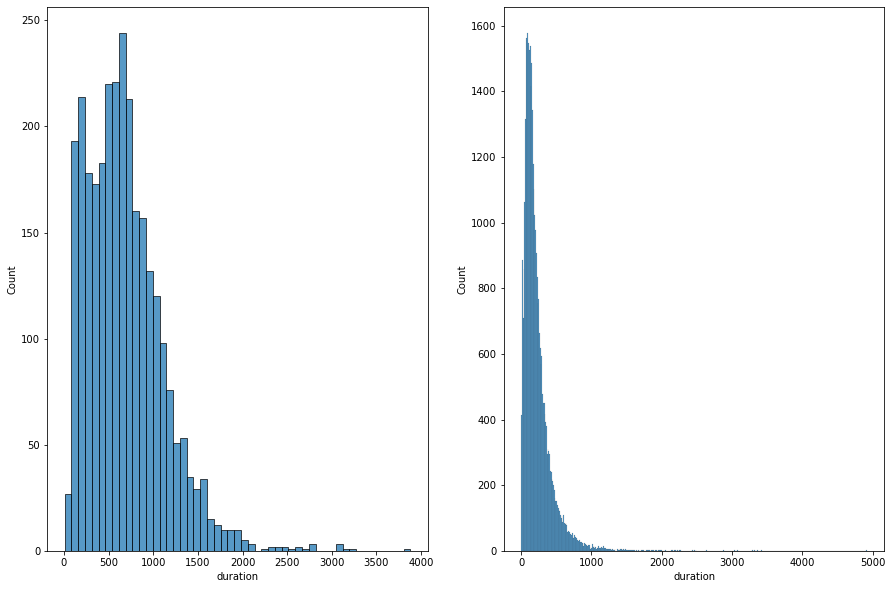

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
bins=5
sns.histplot(data=data1, x=data1['duration'], ax=ax[0])
sns.histplot(data=data2, x=data2['duration'], ax=ax[1])

plt.show()

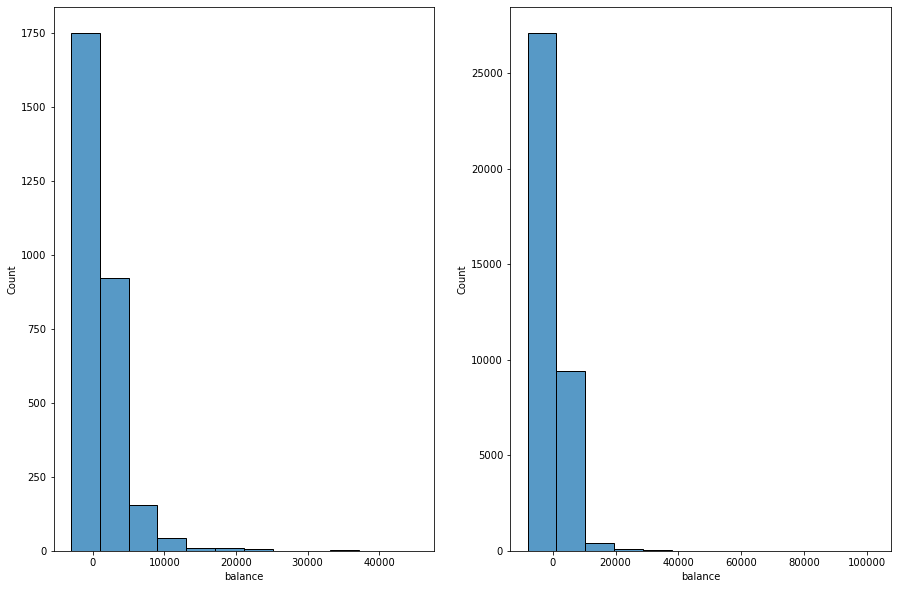

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
bins=12

sns.histplot(data=data1, x=data1['balance'], ax=ax[0],bins=bins)
sns.histplot(data=data2, x=data2['balance'], ax=ax[1],bins=bins)

plt.show()

- Age range from 30 to 60 are the main targets.
- Calls are mostly 10 min or less
- Balance is mostly below 5000

# # Statistical Analysis

In [12]:
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign']
data_mean = pd.DataFrame(data = {1 : list(deposit_df[deposit_df.y == 'yes'].describe().T['mean']), 
                                      0 : list(deposit_df[deposit_df.y == 'no'].describe().T['mean'])},
                              index = numeric_features)
data_mean.T

,age,balance,day,duration,campaign
1,39.844959,1588.495856,15.827003,682.958564,2.414365
0,40.599208,1249.752533,16.032072,221.408042,2.918688


In [13]:
data_median = pd.DataFrame(data = {1 : list(deposit_df[deposit_df.y == 'yes'].describe().T['50%']), 
                                      0 : list(deposit_df[deposit_df.y == 'no'].describe().T['50%'])},
                              index = numeric_features)
data_median.T

,age,balance,day,duration,campaign
1,37.0,620.0,16.0,629.0,2.0
0,39.0,395.0,17.0,164.0,2.0


In [14]:
data_max = pd.DataFrame(data = {1 : list(deposit_df[deposit_df.y == 'yes'].describe().T['max']), 
                                      0 : list(deposit_df[deposit_df.y == 'no'].describe().T['max'])},
                              index = numeric_features)
data_max.T

,age,balance,day,duration,campaign
1,95.0,45248.0,31.0,3881.0,32.0
0,94.0,102127.0,31.0,4918.0,63.0


- On average Subscribers are People who are:
    - about age 35 - 40 years.
    - Has balance of about 1500.
    - mostly subscribes during the middle of the month.
    - Are on call for about 10 minutes.
    - Mostly from campaign 2.

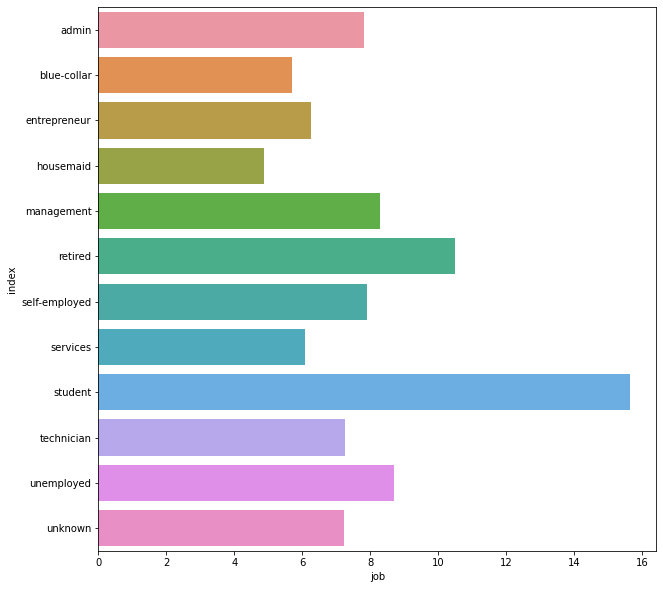

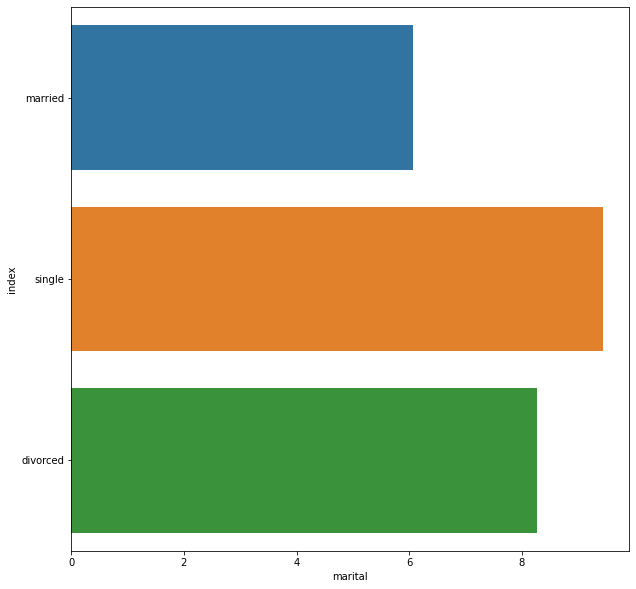

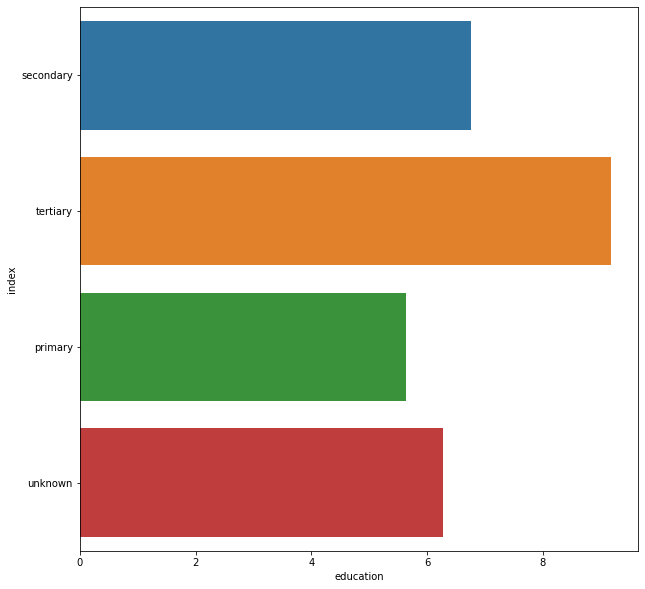

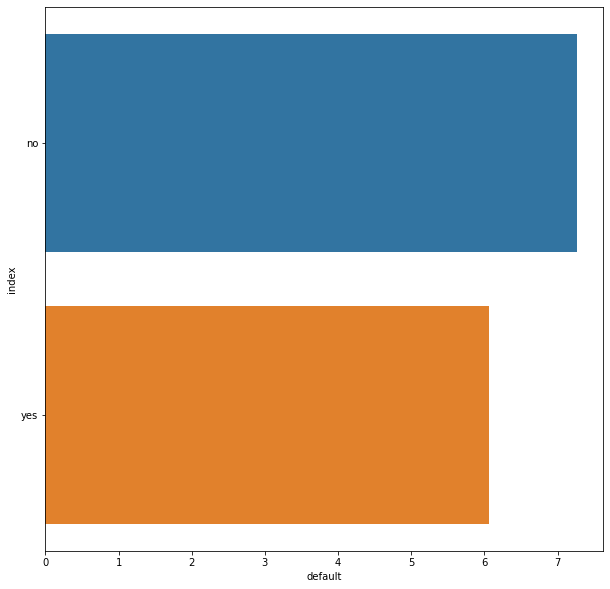

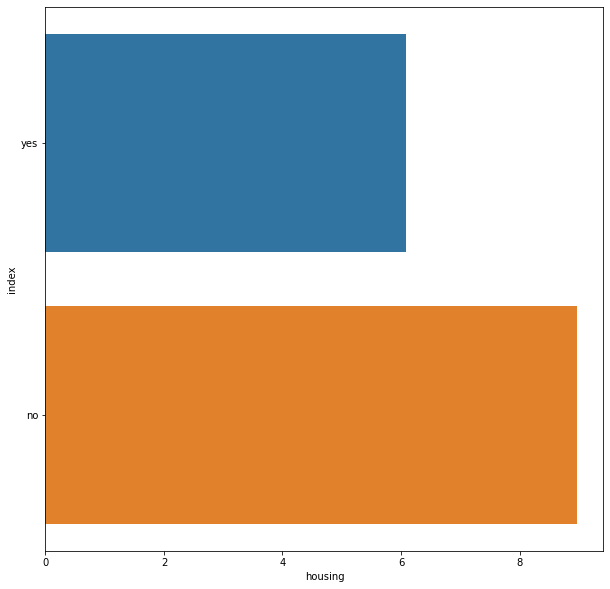

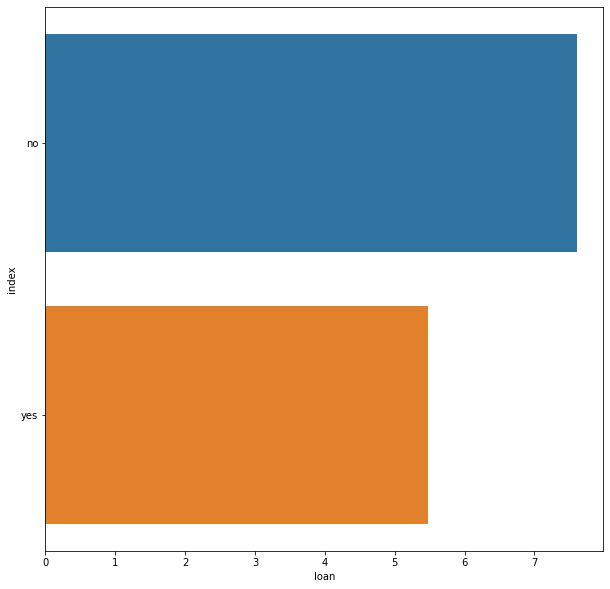

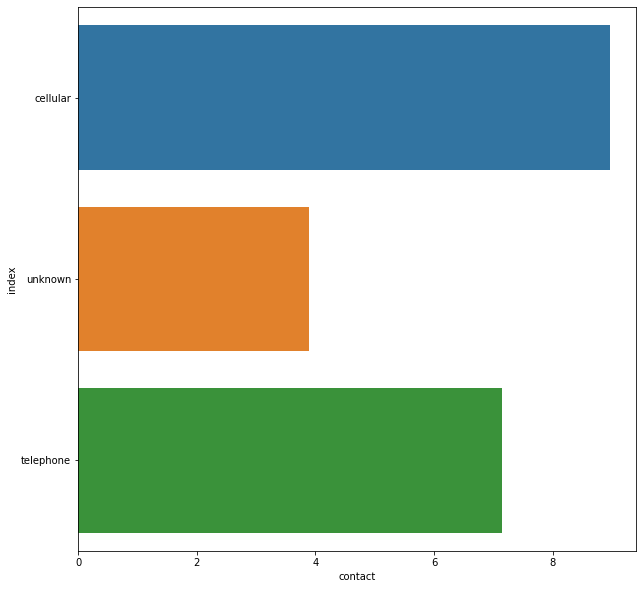

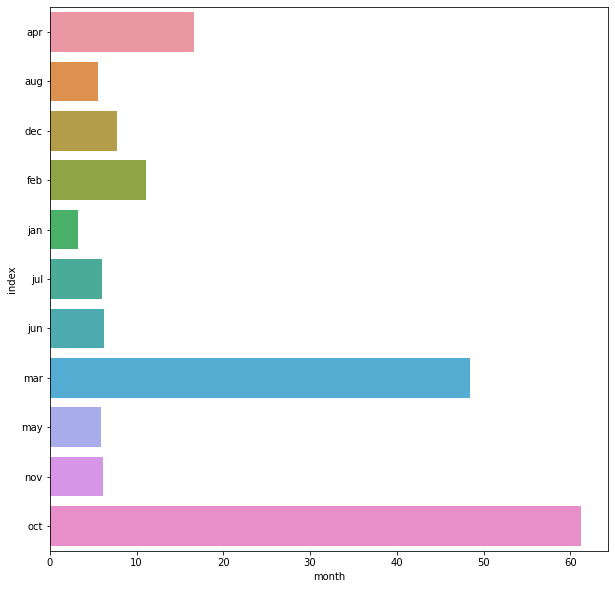

In [15]:
cat_features = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month']
for i in cat_features:
    ratio = deposit_df[i].loc[(deposit_df.y == 'yes')].value_counts()/deposit_df[i].value_counts()*100
    ratio = ratio.reset_index()
    plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sns.barplot(data=ratio, y='index', x=i)#, order=ratio.index)
    #plt.xticks(rotation = 90)
    plt.show()

- People who are more likely to subscribe are :
    - Students, retires.
    - Singles
    - clients with tertiary education
    - people with no housing and/or personal loans.
    
- October and March show one of the highest subscription rates while these months were among least targeted.

# DATA CLEANING

- change data types to the appropriate type.
- Impute any missing data

## REFORMATTING

- Change default status, housing, loan, and y to boolean values.
- Leave Job and Education 'Unknown' as it is.

In [16]:
#make a copy of the data in case you need the original
df1 = deposit_df.copy()

In [17]:
#change default to a boolean
df1.loc[df1.default =='yes', 'default'] = 1
df1.loc[df1.default =='no', 'default'] = 0
df1.default = df1.default.astype('int64')

#change housing to a boolean
df1.loc[df1.housing =='yes', 'housing'] = 1
df1.loc[df1.housing =='no', 'housing'] = 0
df1.housing = df1.housing.astype('int64')

#change loan to a boolean 
df1.loc[df1.loan =='yes', 'loan'] = 1
df1.loc[df1.loan =='no', 'loan'] = 0
df1.loan = df1.loan.astype('int64')

#change y to a boolean
df1.loc[df1.y =='yes', 'y'] = 1
df1.loc[df1.y =='no', 'y'] = 0
df1.y = df1.y.astype('int64')

Because there are so many missing and unknown values for contact by cellular or telephone, we can impute this data by backfilling. We will assume that all points of contact by the user are only made over the phone and not in person or by email. This logically only leaves two options: a cellphone or landline.

In [18]:
#change unknown values in cellular to a NAN value
df1.loc[df1.contact == 'unknown', 'contact'] = np.nan

#back fill contact information
df1.contact.fillna(method='bfill', inplace=True)

# PRE-PROCESSING

### TRANSFORMATION (TESTING SKEWNESS)

- Before we model on the data, we need to look at some ways to transform each feature and normalize the data. Let's take a look at the skew and kurtosis. Skew is the measure of symmetry of the data on the left and right of the centerpoint and kurtosis measures how heavily tailed the data is relative to the normal distribution.
- One-Hot or Label Encoding: We will change the categorical variables to numerically encoded values and see if the data is still skewed and needs to be transformed. We may not need to transform the data if the skew threshold is less than +/- 0.5
- Evaluate Model Accuracy: Using pycaret, we will check the accuracy and recall metric of our data. This is to ensure that the model is able to capture the smaller class.

In [19]:
df1.agg(['skew', 'kurtosis']).T

,skew,kurtosis
age,0.436080,-0.503828
default,6.816736,44.470109
balance,8.259236,141.833247
housing,-0.411561,-1.830709
loan,1.726785,0.981834
day,0.067930,-1.052935
duration,3.165307,18.189852
campaign,4.730901,36.223536
y,3.300155,8.891467


In [20]:
df1.describe()

,age,default,balance,housing,loan,day,duration,campaign,y
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,0.020225,1274.277550,0.600775,0.173250,16.017225,254.824300,2.882175,0.072400
std,9.641776,0.140771,2903.769716,0.489745,0.378468,8.278127,259.366498,3.239051,0.259152
min,19.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,33.000000,0.000000,54.000000,0.000000,0.000000,8.000000,100.000000,1.000000,0.000000
50%,39.000000,0.000000,407.000000,1.000000,0.000000,17.000000,175.000000,2.000000,0.000000
75%,48.000000,0.000000,1319.000000,1.000000,0.000000,21.000000,313.000000,3.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,1.000000


In [21]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,cellular,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,cellular,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,cellular,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,cellular,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,cellular,5,may,198,1,0


### DUMMY VARIABLES

In [22]:
#create a new dataframe
#get dummies for non-ordinal features
df2 = df1.copy()
df2 = pd.get_dummies(df2)
df2

,age,default,balance,housing,loan,day,duration,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,261,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,44,0,29,1,0,5,151,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,33,0,2,1,1,5,76,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,47,0,1506,1,0,5,92,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
4,33,0,1,0,0,5,198,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,0,395,0,0,3,107,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
39996,30,0,3340,0,0,3,238,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
39997,54,0,200,0,0,3,170,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
39998,34,0,1047,0,0,3,342,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [23]:
df2.agg(['skew']).T

,skew
age,0.436080
default,6.816736
balance,8.259236
housing,-0.411561
loan,1.726785
day,0.067930
duration,3.165307
campaign,4.730901
y,3.300155
job_admin,2.459527


# TRAIN TEST SPLIT

In [24]:
# Create our features
y = df2["y"]
X = df2.drop("y", axis=1)
X

,age,default,balance,housing,loan,day,duration,campaign,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,261,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,44,0,29,1,0,5,151,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,33,0,2,1,1,5,76,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,47,0,1506,1,0,5,92,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
4,33,0,1,0,0,5,198,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,0,395,0,0,3,107,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
39996,30,0,3340,0,0,3,238,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
39997,54,0,200,0,0,3,170,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
39998,34,0,1047,0,0,3,342,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [25]:
# Check the balance of our target values
y.value_counts()

0    37104
1     2896
Name: y, dtype: int64

<AxesSubplot:xlabel='y', ylabel='count'>

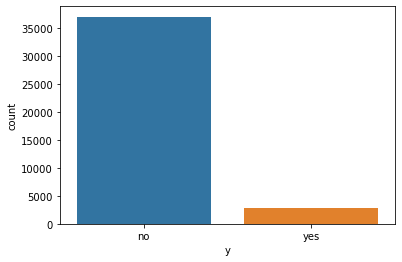

In [26]:
sns.countplot(deposit_df['y'])

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=42)

# Random OverSampling

We need to resample the data since the target class is highly imbalanced.

In [28]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [29]:
Counter(y_resampled)

Counter({0: 31529, 1: 31529})

<AxesSubplot:xlabel='y', ylabel='count'>

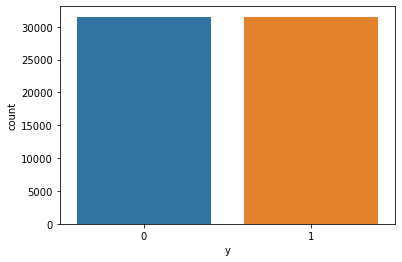

In [30]:
sns.countplot(y_resampled)

MODEL REVIEW
Let's look at which model performs the best based on our current feature engineering.

Because, the bank would like to determine the number of customers that will subscribe to a term market deposit, we want to look at the recall metric for our positive class.

Recall measures how many positive classes (subscribed customers) are predicted correctly divided by the total number of subscribed users predicted correctly and incorrectly.

We want to maximize the number of users predicted correctly to optimize the company's profit.

In [31]:
def get_best_model(data):
    
    clf = setup(data, target = data.columns[-1], silent = True, verbose = False)
    #compare the models
    top5 = compare_models(n_select = 3) 
    #find the best model
    best = automl(optimize = 'Accuracy')

    print(best)
    
    return None

In [32]:
get_best_model(df2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0270
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,0.9857,0.9923,0.9923,0.9926,0.3380
qda,Quadratic Discriminant Analysis,0.9999,0.9633,0.9267,1.0000,0.9596,0.9595,0.9614,0.0540
catboost,CatBoost Classifier,0.9997,0.9999,0.9300,0.9315,0.9218,0.9216,0.9261,3.9370
nb,Naive Bayes,0.9996,0.9999,0.9633,0.8729,0.9113,0.9111,0.9145,0.0270
xgboost,Extreme Gradient Boosting,0.9992,0.9998,0.6633,0.9233,0.7564,0.7560,0.7737,0.9570
lr,Logistic Regression,0.9991,0.9999,0.5900,0.9100,0.7040,0.7036,0.7260,1.0550
et,Extra Trees Classifier,0.9990,0.9999,0.5400,0.9800,0.6722,0.6718,0.7123,0.2950
dt,Decision Tree Classifier,0.9989,0.8664,0.7333,0.7519,0.7366,0.7360,0.7390,0.0270
rf,Random Forest Classifier,0.9988,0.9995,0.3900,0.9000,0.5314,0.5310,0.5836,0.4050


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=7354,
                solver='auto', tol=0.001)


# Modeling

In [33]:
def evaluate_model(classifier):
    
    clf = classifier
    clf.fit(X_train,y_train)
    y_pr = clf.predict(X_test)
    
    # use 5-fold cross validation for average scores
    cv_score = cross_val_score(clf, X=X_train, y=y_train, cv=5)
    score = clf.score(X_train, y_train)
    accuracy = accuracy_score(y_test, y_pr)
    
    print(f'5-CV Scores: {cv_score}\nAverage 5-CV score: {cv_score.mean()}')    
    print(f'Train score: {score}\nTest accuracy: {accuracy}\nDifference: {score - accuracy}')
    
    return clf, y_pr

def plot_confusion_matrix(test, pred, title):

    cm = confusion_matrix(test, pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize=(10, 5))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f'{title} Confusion Matrix')

    return None

def plot_roc_auc(model):
    
    plt.figure(figsize=(15,10))
    # get the probabilities
    model_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, model_prob)
    plt.plot(fpr, tpr, color = 'green')
    plt.plot([0,1], [0, 1], color='blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.show()

In [34]:
def get_model_info(model, title):
    
    # evaluate model
    clf, y_pr = evaluate_model(model)
    # get classification report
    cr = classification_report(y_test, y_pr)
    print(f'\n{title.title()} Classification Report\n\n{cr}')
    # plot confusion matrix
    plot_confusion_matrix(y_test, y_pr, title.title())
    # plot roc auc curve
    plot_roc_auc(clf)
    
    return clf

### ADA Boost

5-CV Scores: [0.92941176 0.92779412 0.93014706 0.92764706 0.92838235]
Average 5-CV score: 0.9286764705882353
Train score: 0.930264705882353
Test accuracy: 0.9333333333333333
Difference: -0.0030686274509803546

Adaboost Classifier Classification Report

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5575
           1       0.56      0.29      0.38       425

    accuracy                           0.93      6000
   macro avg       0.75      0.64      0.67      6000
weighted avg       0.92      0.93      0.92      6000



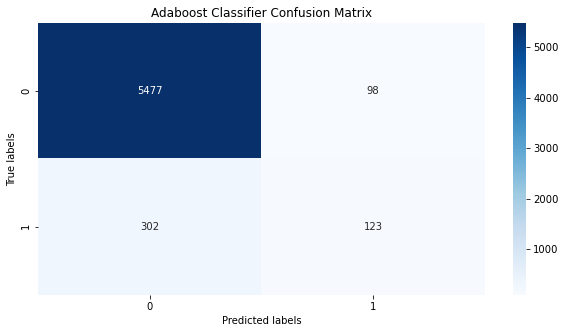

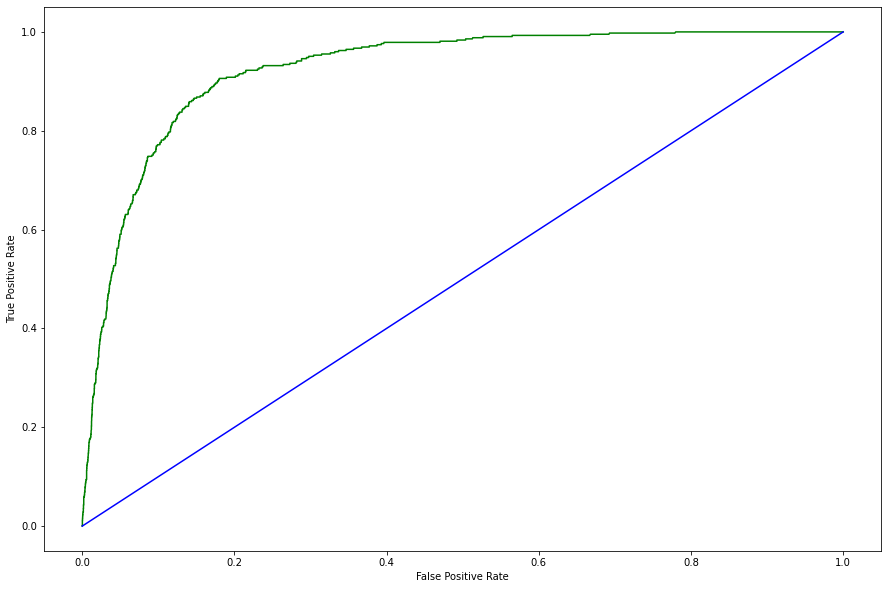

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [35]:
ada = AdaBoostClassifier()
get_model_info(ada, 'AdaBoost Classifier')

### LDA

5-CV Scores: [0.93132353 0.92955882 0.93161765 0.9275     0.935     ]
Average 5-CV score: 0.9309999999999998
Train score: 0.931264705882353
Test accuracy: 0.937
Difference: -0.005735294117647061

Linear Discriminant Analysis Classification Report

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5575
           1       0.57      0.43      0.49       425

    accuracy                           0.94      6000
   macro avg       0.77      0.70      0.73      6000
weighted avg       0.93      0.94      0.93      6000



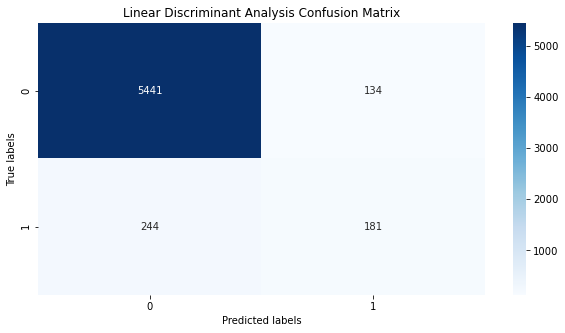

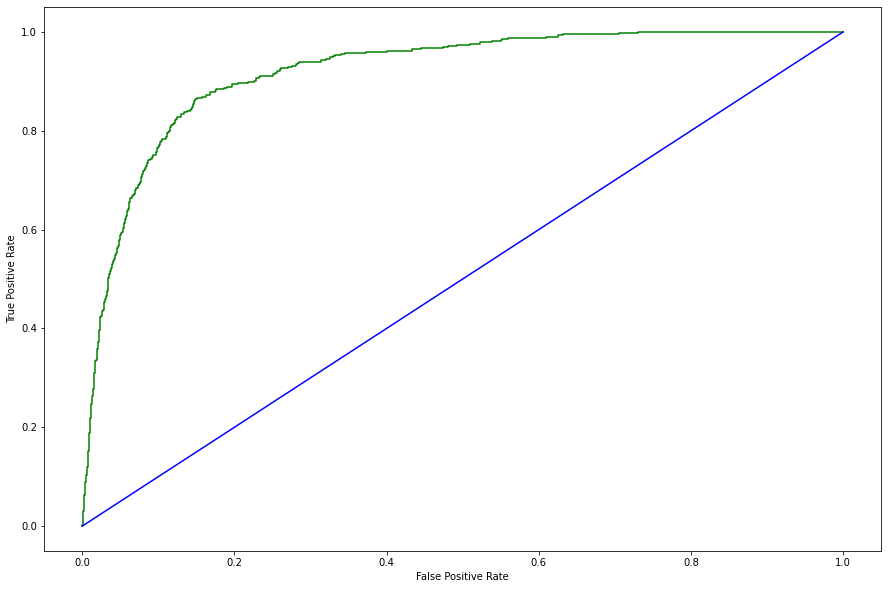

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [36]:
lda = LinearDiscriminantAnalysis()
get_model_info(lda, 'Linear Discriminant Analysis')

### Ridge Classifier

In [37]:
rc = RidgeClassifier()
rc.fit(X_train,y_train)
score = rc.score(X_train,y_train)
print("Score: ", score)

Score:  0.9318235294117647


In [38]:
cv_scores = cross_val_score(rc, X_train,y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())



CV average score: 0.93


Text(0.5, 1.0, ' Confuson Matrix')

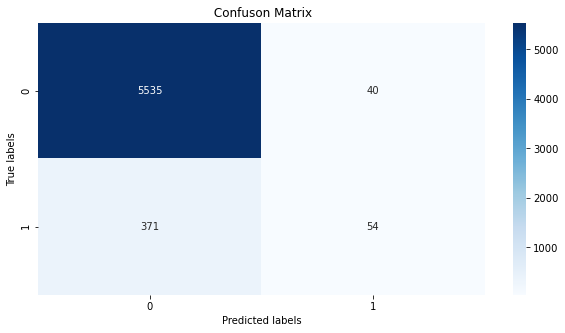

In [39]:
ypred = rc.predict(X_test)

cm = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title(' Confuson Matrix')

In [40]:
cr = classification_report(y_test, ypred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5575
           1       0.57      0.13      0.21       425

    accuracy                           0.93      6000
   macro avg       0.76      0.56      0.59      6000
weighted avg       0.91      0.93      0.91      6000



### RANDOM FOREST

5-CV Scores: [0.93352941 0.93558824 0.93367647 0.93191176 0.93676471]
Average 5-CV score: 0.9342941176470587
Train score: 0.9999705882352942
Test accuracy: 0.9356666666666666
Difference: 0.06430392156862752

Random Forest Classification Report

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5575
           1       0.59      0.30      0.40       425

    accuracy                           0.94      6000
   macro avg       0.77      0.64      0.68      6000
weighted avg       0.92      0.94      0.93      6000



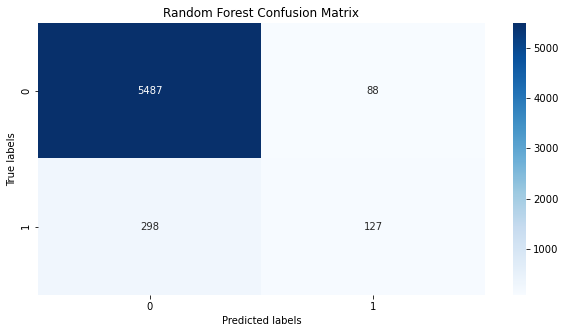

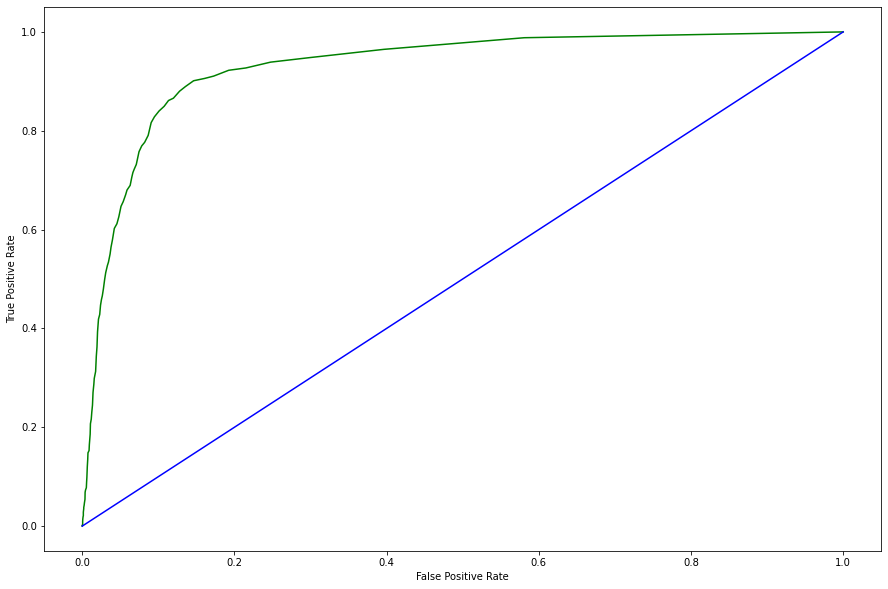

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
rf = RandomForestClassifier()#n_estimators=200, criterion='gini', random_state=seed)
get_model_info(rf, 'Random Forest')

### Conclusion

In conclusion, we will go ahead and use Linear Discriminant Analysis, as this model is able to recognize the smallest class the best at a recall rate of 43% while maintaining an average 5-fold cross-validation score of 93% and an F1-score accuracy of 94%.

In [42]:
# List the features sorted in descending order by feature importance
# Calculate feature importance in the Random Forest model.
importances = rf.feature_importances_
# We can sort the features by their importance.
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.3664939396906423, 'duration'),
 (0.11761675970352185, 'balance'),
 (0.1019304496055013, 'day'),
 (0.10120492729565223, 'age'),
 (0.046129077684435416, 'campaign'),
 (0.01960264469201256, 'housing'),
 (0.01826099412212561, 'month_mar'),
 (0.016497037853528185, 'month_apr'),
 (0.011782686353645114, 'job_technician'),
 (0.011563656999149567, 'loan'),
 (0.011410161322427304, 'education_secondary'),
 (0.010809166351590719, 'job_management'),
 (0.010181485824284776, 'education_tertiary'),
 (0.010055895352856482, 'job_blue-collar'),
 (0.010022516181751364, 'month_may'),
 (0.009504493563624797, 'job_admin'),
 (0.008834947792691481, 'marital_married'),
 (0.008313814577095749, 'month_oct'),
 (0.008077524563932018, 'month_jul'),
 (0.007568326916081161, 'marital_single'),
 (0.007446633189907085, 'month_feb'),
 (0.007335916444130895, 'job_services'),
 (0.00699139355520812, 'month_jun'),
 (0.006974334711370932, 'education_primary'),
 (0.00639447219671394, 'marital_divorced'),
 (0.006177472998153

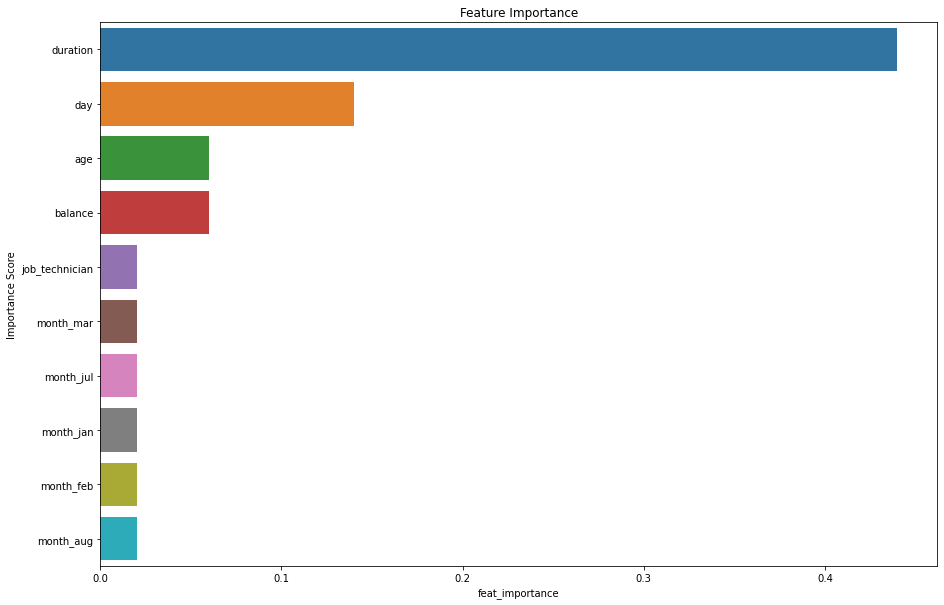

In [43]:
feat_select = pd.DataFrame(data = {'features': X_train.columns, 'feat_importance': ada.feature_importances_})
top_10 = feat_select.sort_values(by='feat_importance', ascending=False).head(10)

# show top 10 most important features
plt.figure(figsize=(15,10))
sns.barplot(data=top_10, y='features', x='feat_importance', order=top_10.features)
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.show()

Based on above feature importance,duration of the call  is the largest determining factor in whether or not a person will subscribe followed by day of the week, customer's age and whether if a customer has a negative balance.